# Практическая работа №2 (Исследовательский анализ данных (EDA) и визуализация зависимостей)

**Выполнил:** Хайбулин Никита Сергеевич (гр. 955-М)

**Вариант:** 16 (датасет Diamonds — пропуски, поиск нулевых значений в x, y, z)  

---

## Цель работы
1. Провести исследовательский анализ данных (EDA) на выбранном датасете.  
2. Выполнить три задания:  
   - сравнение стратегий обработки пропусков,
   - детекция и визуализация выбросов,  
   - инженерия признаков и проверка гипотезы полезности нового признака.  

In [3]:
import sys, subprocess
from importlib.metadata import version, PackageNotFoundError

def ensure_package(pkg_spec: str):
    # Устанавливает пакет через pip, если его нет (или если нужно обновить — см. ниже).
    pkg_name = pkg_spec.split("==")[0].split(">=")[0].split("<=")[0]
    try:
        version(pkg_name)
    except PackageNotFoundError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg_spec])

# missingno — для визуализации пропусков
ensure_package("missingno>=0.5.2")

# seaborn — для графиков; нужна версия, совместимая с pandas 2.x
ensure_package("seaborn>=0.13.2")

# На всякий случай обновим seaborn (если уже был установлен, но старый)
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "--upgrade", "seaborn>=0.13.2"])

print("✅ Библиотеки готовы.")


✅ Библиотеки готовы.


In [4]:

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import missingno as msno

from pathlib import Path


In [24]:

# Загрузка данных: (1) локальный файл рядом с ноутбуком, (2) /mnt/data (для автопроверки),
# (3) seaborn.load_dataset, (4) прямой URL как запасной вариант.

CANDIDATE_PATHS = [Path("diamonds.csv"), Path("/mnt/data/diamonds.csv")]

df = None
for p in CANDIDATE_PATHS:
    if p.exists():
        df = pd.read_csv(p)
        print(f"✅ Загружено из файла: {p}")
        break

if df is None:
    try:
        df = sns.load_dataset("diamonds")
        print("✅ Загружено через seaborn.load_dataset('diamonds')")
    except Exception as e:
        print("⚠️ seaborn.load_dataset не сработал, пробую загрузку по URL…")
        url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/diamonds.csv"
        df = pd.read_csv(url)

df.head()


✅ Загружено через seaborn.load_dataset('diamonds')


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## 1. Краткое описание данных
Размерность датасета, типы столбцов и базовая статистика:


In [6]:

print("Shape:", df.shape)
display(df.dtypes)

display(df.describe(include="all").T)


Shape: (53940, 10)


,0
carat,float64
cut,category
color,category
clarity,category
depth,float64
table,float64
price,int64
x,float64
y,float64
z,float64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
carat,53940.0,NaN,NaN,NaN,0.79794,0.474011,0.2,0.4,0.7,1.04,5.01
cut,53940,5,Ideal,21551,NaN,NaN,NaN,NaN,NaN,NaN,NaN
color,53940,7,G,11292,NaN,NaN,NaN,NaN,NaN,NaN,NaN
clarity,53940,8,SI1,13065,NaN,NaN,NaN,NaN,NaN,NaN,NaN
depth,53940.0,NaN,NaN,NaN,61.749405,1.432621,43.0,61.0,61.8,62.5,79.0
table,53940.0,NaN,NaN,NaN,57.457184,2.234491,43.0,56.0,57.0,59.0,95.0
price,53940.0,NaN,NaN,NaN,3932.799722,3989.439738,326.0,950.0,2401.0,5324.25,18823.0
x,53940.0,NaN,NaN,NaN,5.731157,1.121761,0.0,4.71,5.7,6.54,10.74
y,53940.0,NaN,NaN,NaN,5.734526,1.142135,0.0,4.72,5.71,6.54,58.9
z,53940.0,NaN,NaN,NaN,3.538734,0.705699,0.0,2.91,3.53,4.04,31.8


## 2. Вариант 16: «Пропуски», замаскированные под нули в `x`, `y`, `z`
В датасете **размеры** бриллианта (`x`, `y`, `z`) физически не могут быть равны нулю.  
Поэтому нули трактуем как **ошибки измерения / отсутствие данных** и преобразуем в `NaN`.

Поэтому далее:
1) посчитаем количество нулей,  
2) заменим их на `NaN`,  
3) визуализируем паттерны пропусков.


In [7]:

dims = ["x", "y", "z"]

zero_counts = (df[dims] == 0).sum().rename("zero_count")
zero_rows = (df[dims] == 0).any(axis=1).sum()

display(zero_counts.to_frame())
print(f"Строк с хотя бы одним нулём в {dims}: {zero_rows} из {len(df)} ({100*zero_rows/len(df):.2f}%)")

df_miss = df.copy()
df_miss[dims] = df_miss[dims].replace(0, np.nan)

display(df_miss[dims].isna().sum().rename("na_count").to_frame())


,zero_count
x,8
y,7
z,20


Строк с хотя бы одним нулём в ['x', 'y', 'z']: 20 из 53940 (0.04%)


,na_count
x,8
y,7
z,20


### Визуализация пропусков
Используем `missingno` и дополнительно — простую тепловую карту на базе `pandas`/`seaborn`.


<Figure size 1000x500 with 0 Axes>

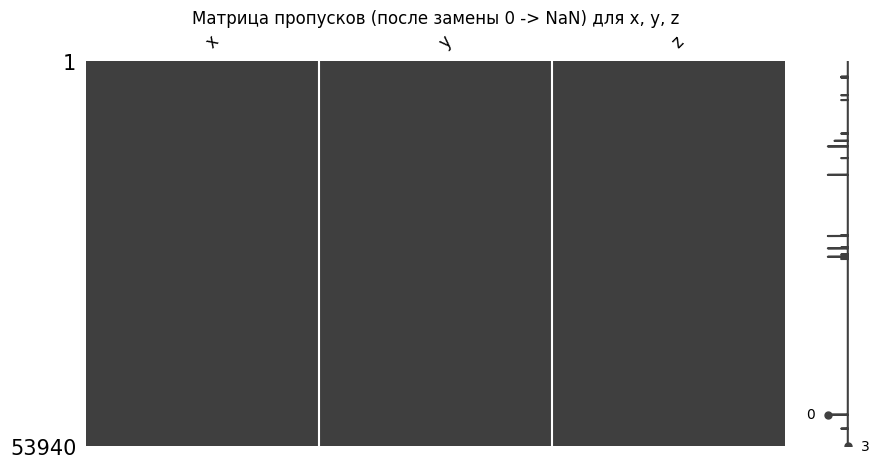

<Figure size 800x600 with 0 Axes>

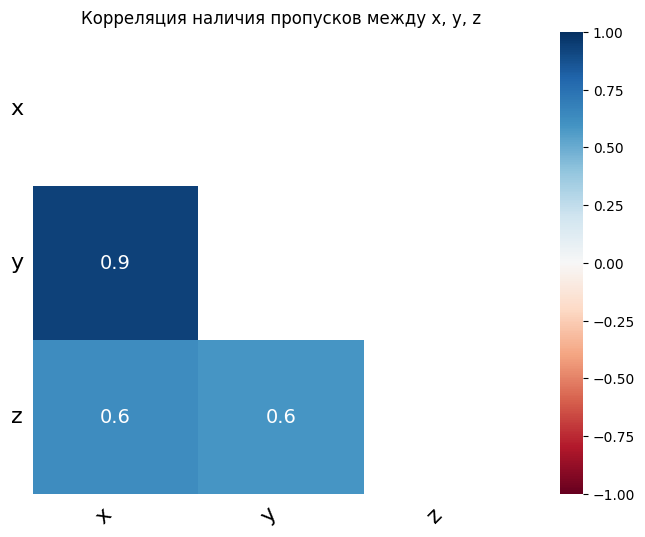

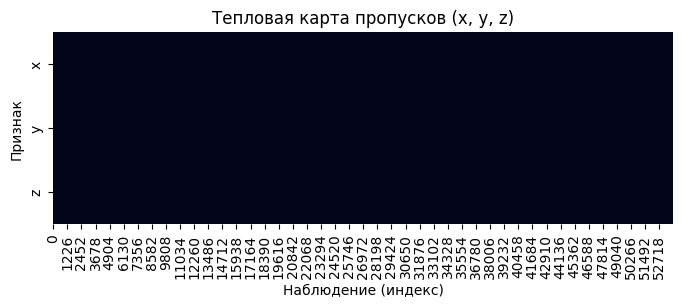

In [22]:

plt.figure(figsize=(10, 5))
msno.matrix(df_miss[dims], figsize=(10, 5), fontsize=12)
plt.title("Матрица пропусков (после замены 0 -> NaN) для x, y, z")
plt.show()

plt.figure(figsize=(8, 6))
msno.heatmap(df_miss[dims], figsize=(8, 6))
plt.title("Корреляция наличия пропусков между x, y, z")
plt.show()

plt.figure(figsize=(8, 2.5))
sns.heatmap(df_miss[dims].isna().T, cbar=False)
plt.title("Тепловая карта пропусков (x, y, z)")
plt.ylabel("Признак")
plt.xlabel("Наблюдение (индекс)")
plt.show()


**Комментарий к графикам:** видно, что пропусков мало (доли процента), но они концентрируются именно в геометрических размерах. Так как нули здесь не имеют физического смысла, корректнее рассматривать их как **пропуски** и восстанавливать значения (или удалять строки), чтобы не ломать дальнейшие вычисления (например, объём `x·y·z`).  


## 3. Задание 1 — Сравнение стратегий импутации  
**Цель:** оценить, какой метод заполнения пропусков меньше искажает распределение признака.

Для варианта 16 выберем признак `z` (в нём больше всего нулей/пропусков) и сравним:
- заполнение **средним**,
- заполнение **медианой** (робастнее к выбросам),
- **KNNImputer** (учитывает близость объектов по другим числовым признакам).

Сравним:
1) гистограммы распределений,  
2) изменение среднего и стандартного отклонения.


In [9]:

from sklearn.impute import KNNImputer

feature = "z"

# Базовое распределение (после замены 0 -> NaN, без заполнения)
base = df_miss[feature].dropna()

# 1) Mean
z_mean = df_miss[feature].fillna(df_miss[feature].mean())

# 2) Median
z_median = df_miss[feature].fillna(df_miss[feature].median())

# 3) KNN (используем только числовые признаки)
num_cols = df_miss.select_dtypes(include=[np.number]).columns.tolist()
imputer = KNNImputer(n_neighbors=5, weights="distance")

num_imp = pd.DataFrame(imputer.fit_transform(df_miss[num_cols]), columns=num_cols, index=df_miss.index)
z_knn = num_imp[feature]

# Таблица изменения статистик
stats = pd.DataFrame({
    "mean": [base.mean(), z_mean.mean(), z_median.mean(), z_knn.mean()],
    "std":  [base.std(),  z_mean.std(),  z_median.std(),  z_knn.std()]
}, index=["до_заполнения (NaN исключены)", "Mean", "Median", "KNN(k=5)"])

stats["|Δmean|"] = (stats["mean"] - stats.loc["до_заполнения (NaN исключены)", "mean"]).abs()
stats["|Δstd|"]  = (stats["std"]  - stats.loc["до_заполнения (NaN исключены)", "std"]).abs()

display(stats)


,mean,std,|Δmean|,|Δstd|
до_заполнения (NaN исключены),3.540046,0.702530,0.000000e+00,0.000000
Mean,3.540046,0.702400,4.440892e-16,0.000130
Median,3.540043,0.702400,3.725015e-06,0.000130
KNN(k=5),3.540327,0.702637,2.801427e-04,0.000107


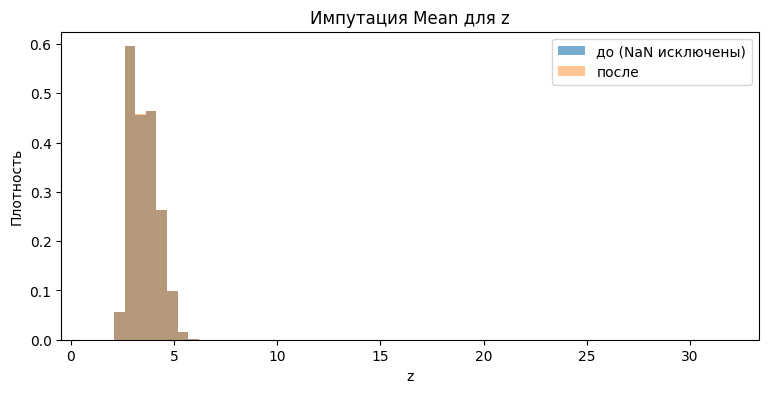

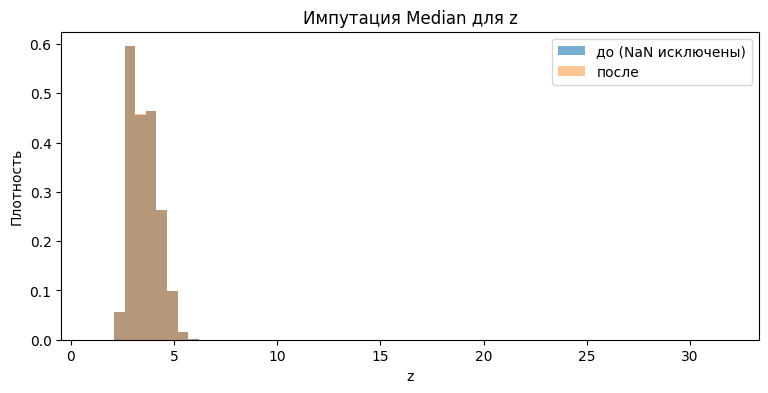

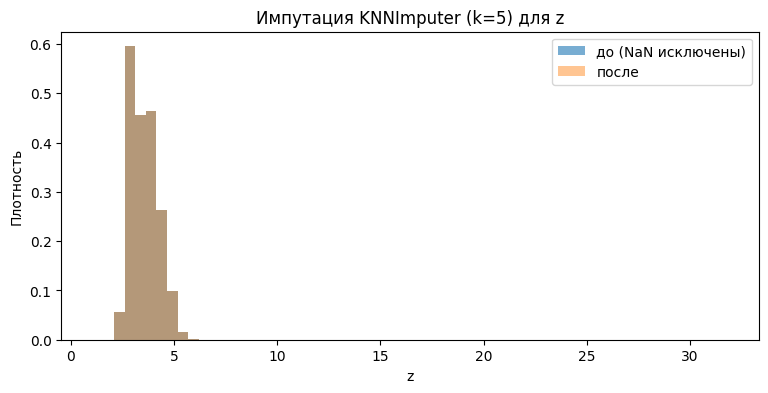

In [10]:

# Визуализация: "до" (без заполнения) vs после каждого метода
# Используем matplotlib.hist, чтобы избежать несовместимостей seaborn.histplot в некоторых окружениях.

bins = 60

def plot_before_after(before, after, title):
    plt.figure(figsize=(9, 4))
    plt.hist(before, bins=bins, density=True, alpha=0.6, label="до (NaN исключены)")
    plt.hist(after,  bins=bins, density=True, alpha=0.45, label="после")
    plt.title(title)
    plt.legend()
    plt.xlabel(feature)
    plt.ylabel("Плотность")
    plt.show()

plot_before_after(base, z_mean,   "Импутация Mean для z")
plot_before_after(base, z_median, "Импутация Median для z")
plot_before_after(base, z_knn,    "Импутация KNNImputer (k=5) для z")


**Вывод по заданию 1:**  
Так как пропусков очень мало, все методы почти не меняют среднее/стандартное отклонение.  
Практический критерий выбора здесь — **устойчивость и интерпретируемость**:  
- *Median* обычно предпочтительнее при потенциальных выбросах (робастность),  
- *KNNImputer* полезен, если пропусков больше и есть сильные зависимости между признаками, но требует масштабирования и дороже по вычислениям.  

Для дальнейшей работы в ноутбуке используем **медианную импутацию** для `x`, `y`, `z` как простую и устойчивую стратегию.


In [11]:

df_clean = df_miss.copy()
for col in ["x", "y", "z"]:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

print("Пропуски после заполнения x,y,z:", int(df_clean[["x","y","z"]].isna().sum().sum()))
df_clean[["x","y","z"]].describe().T


Пропуски после заполнения x,y,z: 0


,count,mean,std,min,25%,50%,75%,max
x,53940.0,5.732003,1.119587,3.73,4.71,5.70,6.54,10.74
y,53940.0,5.735267,1.140265,3.68,4.72,5.71,6.54,58.90
z,53940.0,3.540043,0.702400,1.07,2.91,3.53,4.04,31.80


## 4. Задание 2 — Детекция и визуализация выбросов  
**Цель:** научиться находить и аргументированно интерпретировать выбросы.

Шаги:
1) найдём числовой признак с наибольшей корреляцией с `price`,  
2) для этого признака найдём выбросы методами **IQR** и **Z-Score**,  
3) визуализируем на Boxplot и Scatterplot,  
4) посчитаем долю выбросов.


In [12]:

from scipy import stats as scipy_stats

# Корреляции числовых признаков с ценой
num_cols = df_clean.select_dtypes(include=[np.number]).columns
corr_to_price = df_clean[num_cols].corr(numeric_only=True)["price"].sort_values(ascending=False)

display(corr_to_price.to_frame("corr_with_price"))

main_feature = corr_to_price.index[1]  # после 'price' идёт лучший предиктор
print("Выбран признак по корреляции с price:", main_feature)


,corr_with_price
price,1.000000
carat,0.921591
x,0.886999
y,0.867649
z,0.867569
table,0.127134
depth,-0.010647


Выбран признак по корреляции с price: carat


In [13]:

x = df_clean[main_feature]

# IQR
q1, q3 = x.quantile([0.25, 0.75])
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
out_iqr = (x < lower) | (x > upper)

# Z-score
z = np.abs(scipy_stats.zscore(x))
out_z = z > 3

print(f"IQR границы: [{lower:.3f}, {upper:.3f}]")
print(f"Выбросов по IQR: {out_iqr.sum()} ({100*out_iqr.mean():.2f}%)")
print(f"Выбросов по Z-score: {out_z.sum()} ({100*out_z.mean():.2f}%)")


IQR границы: [-0.560, 2.000]
Выбросов по IQR: 1889 (3.50%)
Выбросов по Z-score: 439 (0.81%)


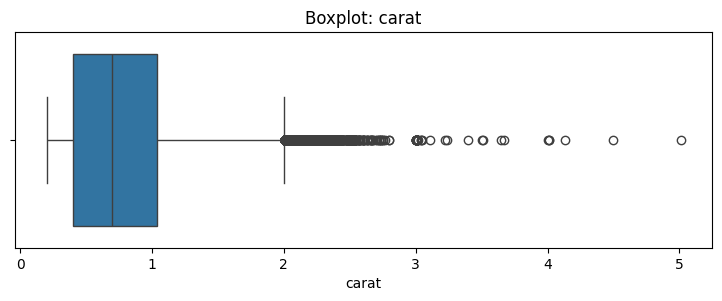

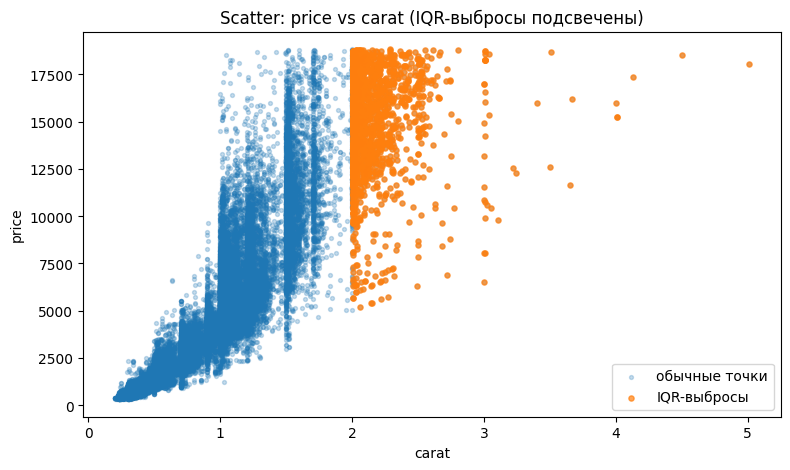

In [14]:

# Boxplot для основного признака
plt.figure(figsize=(9, 2.8))
sns.boxplot(x=df_clean[main_feature])
plt.title(f"Boxplot: {main_feature}")
plt.xlabel(main_feature)
plt.show()

# Scatterplot: связь main_feature с price; подсветим IQR-выбросы красным
plt.figure(figsize=(9, 5))
plt.scatter(df_clean[main_feature], df_clean["price"], s=8, alpha=0.25, label="обычные точки")
plt.scatter(df_clean.loc[out_iqr, main_feature], df_clean.loc[out_iqr, "price"], s=14, alpha=0.7, label="IQR-выбросы")
plt.title(f"Scatter: price vs {main_feature} (IQR-выбросы подсвечены)")
plt.xlabel(main_feature)
plt.ylabel("price")
plt.legend()
plt.show()


**Вывод по заданию 2:**  
Для `Diamonds` наиболее сильная линейная связь с `price` наблюдается у `carat`, поэтому именно его удобно считать «ключевым» числовым признаком.  
Выбросы по `carat` в основном отражают **редкие крупные камни** (это не «ошибки», а значимые наблюдения).  

Практическая рекомендация:
- если цель — предсказание цены в типичном сегменте, можно рассмотреть **capping** (обрезку верхних 1–2% значений),  
- если цель — универсальная модель (включая дорогой сегмент), удалять такие строки не стоит: это «ценная информация», а не шум.


## 5. Задание 3 — Инженерия признаков и проверка гипотезы  
**Гипотеза:** геометрический **объём** бриллианта `volume = x · y · z` будет полезным признаком для модели и покажет сильную связь с `price`.

Шаги:
1) создадим `volume`,  
2) построим корреляционную матрицу с новым признаком,  
3) визуализируем зависимость `price` от `volume`,  
4) сравним корреляцию `volume` и исходных признаков с `price`.


In [15]:

df_fe = df_clean.copy()
df_fe["volume"] = df_fe["x"] * df_fe["y"] * df_fe["z"]

# Корреляция числовых признаков с price
num_cols_fe = df_fe.select_dtypes(include=[np.number]).columns
corr_fe = df_fe[num_cols_fe].corr(numeric_only=True)

display(corr_fe["price"].sort_values(ascending=False).to_frame("corr_with_price"))


,corr_with_price
price,1.000000
carat,0.921591
volume,0.903907
x,0.886999
y,0.867649
z,0.867569
table,0.127134
depth,-0.010647


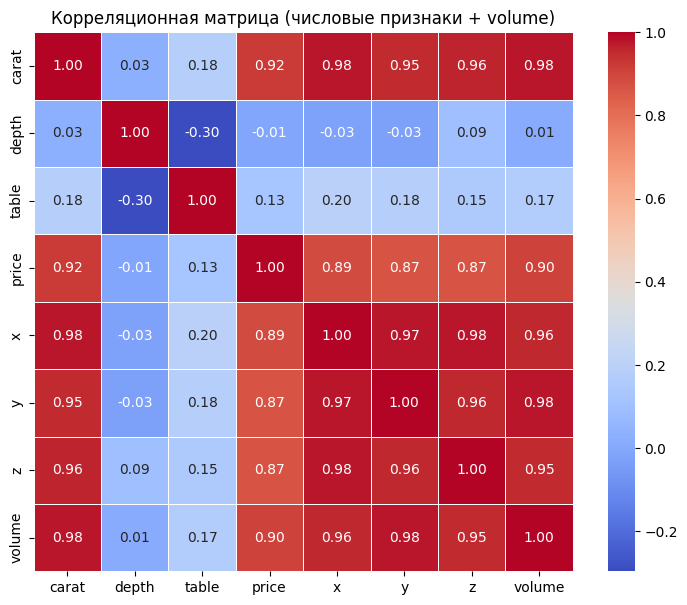

In [18]:

plt.figure(figsize=(9, 7))
sns.heatmap(corr_fe, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.title("Корреляционная матрица (числовые признаки + volume)")
plt.show()


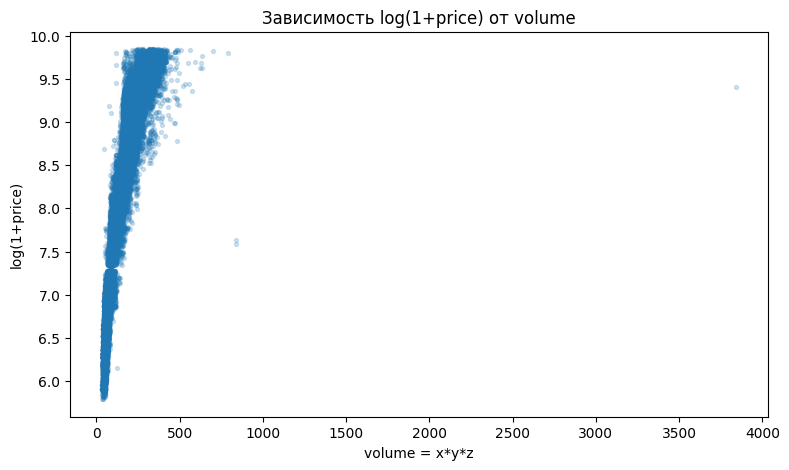

In [19]:

# Диаграмма зависимости цены от объёма (из-за сильного перекоса цены удобно смотреть log(price))
plt.figure(figsize=(9, 5))
plt.scatter(df_fe["volume"], np.log1p(df_fe["price"]), s=8, alpha=0.2)
plt.title("Зависимость log(1+price) от volume")
plt.xlabel("volume = x*y*z")
plt.ylabel("log(1+price)")
plt.show()


**Вывод по заданию 3:**  
Признак `volume` имеет понятный физический смысл и показывает сильную связь с ценой.  
Если `volume` коррелирует с `price` сильнее, чем отдельные `x`, `y`, `z`, то для модели может быть выгодно:
- использовать `volume` вместо тройки `x,y,z` (снизить размерность и мультиколлинеарность),  
- либо оставить и `carat`, и `volume`, а затем проверить важности признаков на модели (например, RandomForest / XGBoost).

Важно: перед вычислением объёма мы **устранили нулевые значения** (иначе объём мог бы стать 0 и породить искусственные выбросы).


## 6. Дополнительный EDA: категориальные признаки и их влияние на цену
Посмотрим, как `cut`, `color`, `clarity` связаны с `price`. Это полезно для понимания, какие категориальные признаки действительно «двигают» цену и как их стоит кодировать.


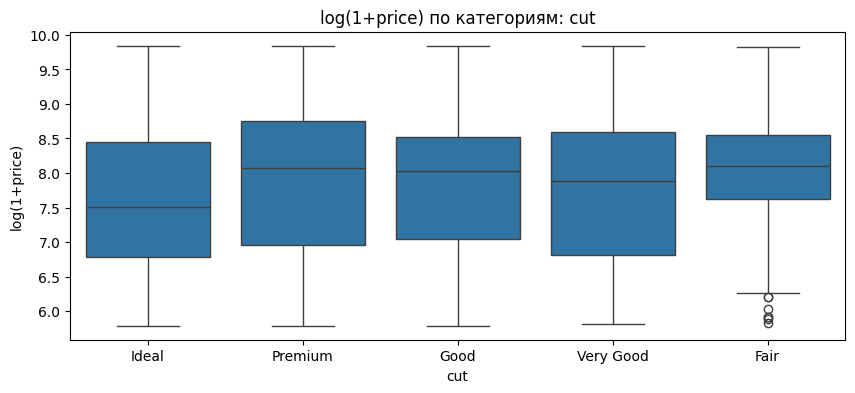

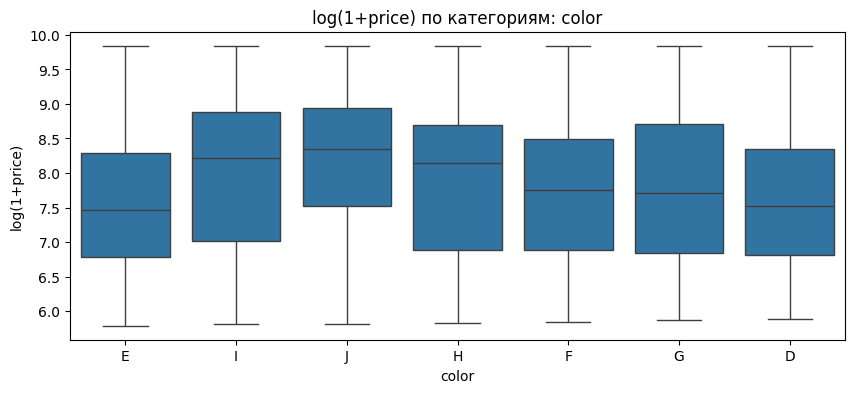

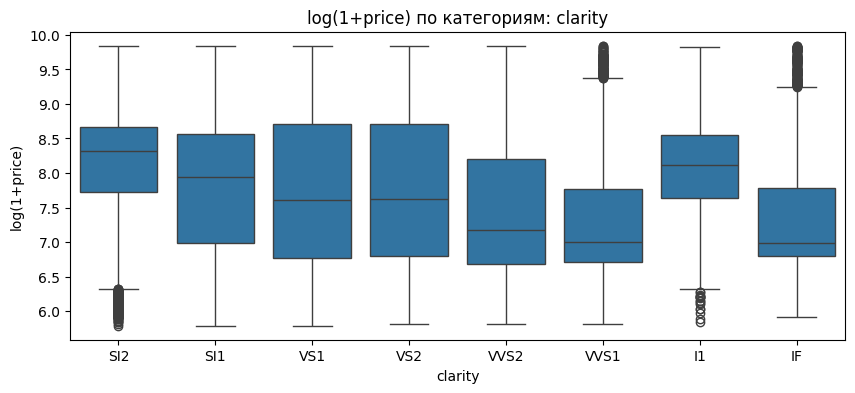

In [ ]:

cat_cols = ["cut", "color", "clarity"]

for col in cat_cols:
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=df_fe, x=col, y=np.log1p(df_fe["price"]))
    plt.title(f"log(1+price) по категориям: {col}")
    plt.xlabel(col)
    plt.ylabel("log(1+price)")
    plt.xticks(rotation=0)
    plt.show()


**Комментарий:** даже при логарифмировании цены видно, что качество огранки/цвет/чистота влияют на распределение цен.  
Для моделей обычно используют:
- One-Hot Encoding (`cut`, `color`, `clarity`),  
- либо более компактные схемы (Ordinal/Target Encoding) — но их нужно делать аккуратно, чтобы не допустить утечку таргета.


## 7. Преобразование признаков и масштабирование (StandardScaler vs MinMaxScaler)
Масштабирование особенно важно для алгоритмов, основанных на расстояниях (KNN, SVM, KMeans) — в том числе для **KNNImputer**, который мы использовали в задании 1 как альтернативу.


,mean_std,std_std,min,max
carat,2.444878e-16,1.000009,-1.261458,8.886075
depth,-3.996902e-15,1.000009,-13.087603,12.041392
table,9.695207e-17,1.000009,-6.470073,16.801666
x,8.219849e-16,1.000009,-1.788178,4.473117
y,-3.161480e-17,1.000009,-1.802464,46.625339
z,1.939041e-16,1.000009,-3.516608,40.233791
volume,-1.095980e-16,1.000009,-1.255556,47.442494


,mean_mm,std_mm,min,max
carat,0.124312,0.098547,0.0,1.0
depth,0.520817,0.039795,0.0,1.0
table,0.278023,0.042971,0.0,1.0
x,0.285592,0.159713,0.0,1.0
y,0.037220,0.020649,0.0,1.0
z,0.080379,0.022857,0.0,1.0
volume,0.025782,0.020535,0.0,1.0


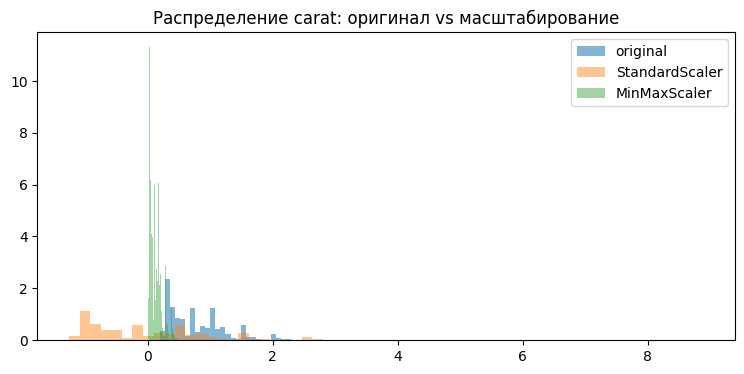

In [20]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler

num_cols = ["carat", "depth", "table", "x", "y", "z", "volume"]

X = df_fe[num_cols].copy()

std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

X_std = pd.DataFrame(std_scaler.fit_transform(X), columns=num_cols)
X_mm  = pd.DataFrame(mm_scaler.fit_transform(X), columns=num_cols)

display(X_std.describe().T[["mean", "std", "min", "max"]].rename(columns={"mean":"mean_std", "std":"std_std"}))
display(X_mm.describe().T[["mean", "std", "min", "max"]].rename(columns={"mean":"mean_mm", "std":"std_mm"}))

# Визуально сравним распределение одного признака до и после масштабирования
feat = "carat"
bins = 60

plt.figure(figsize=(9, 4))
plt.hist(X[feat], bins=bins, density=True, alpha=0.55, label="original")
plt.hist(X_std[feat], bins=bins, density=True, alpha=0.45, label="StandardScaler")
plt.hist(X_mm[feat], bins=bins, density=True, alpha=0.45, label="MinMaxScaler")
plt.title(f"Распределение {feat}: оригинал vs масштабирование")
plt.legend()
plt.show()


## Выводы и гипотезы (итоговый отчёт)
1. **Нулевые значения в `x`, `y`, `z` — это скрытые пропуски.** Их доля невелика, но они критичны для производных признаков (например, объёма).  
   **Действие:** заменять `0 → NaN`, затем выполнять импутацию (или удалять строки, если это приемлемо).

2. **Сравнение импутации (Mean / Median / KNN):** при малой доле пропусков все методы почти не меняют статистику.  
   **Действие:** для простоты и робастности использовать **Median**; KNN рассматривать при большем числе пропусков и после масштабирования.

3. **Ключевой числовой признак для цены — `carat`** (наибольшая корреляция с `price`).  
   **Наблюдение:** «выбросы» по `carat` чаще всего отражают редкие крупные бриллианты и могут быть **ценной частью данных**.  
   **Действие:** вместо удаления рассмотреть **capping** верхних процентов при необходимости.

4. **Инженерия признаков:** `volume = x·y·z` имеет физический смысл и показывает сильную связь с ценой.  
   **Гипотеза для модели:** `volume` может улучшить качество предсказания, особенно совместно с `carat` и категориальными признаками `cut/color/clarity`.

5. **Категориальные признаки** (`cut`, `color`, `clarity`) заметно влияют на `price`.  
   **Действие:** для базовой модели — One-Hot Encoding; для продвинутых моделей — аккуратный Target/Ordinal Encoding (без утечки таргета).
